# Homework 1

<img src="./files/svm.png">

Try to generate datasets like this, fit SVM on each of them and find best regularization parameter and best kernel for each (use CV).

Dataset settings
- 2 features
- not more than 10k points
- you can either try generating from distributions, and maybe removing some elements after 
- or you can just generate by some functions, this would be easier, but it is OK

In [304]:
from sklearn.datasets import make_blobs, make_gaussian_quantiles
from matplotlib import pyplot
import pandas as pd
import numpy as np
from sklearn.svm import SVC

(100, 2)
(100,)


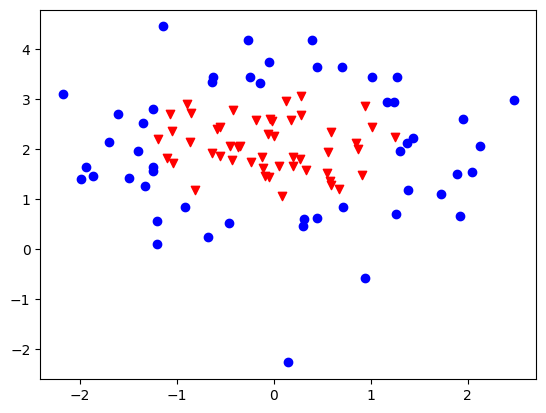

In [373]:
# generate 2d classification dataset
#X, y = make_blobs(n_samples=1000, centers=2, n_features=2, random_state=2234)
X, y = make_gaussian_quantiles(mean=[0, 2], cov=1, n_samples=100, n_features=2, n_classes=2, random_state=None)
print(X.shape)
print(y.shape)
# scatter plot, dots colored by class value
df = pd.DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
X = df.drop(columns=['label'])
y = df['label']
pyplot.scatter(X['x'][y==0],X['y'][y==0],c='red', marker='v')
pyplot.scatter(X['x'][y==1],X['y'][y==1],c='blue', marker='o')
pyplot.show()

In [127]:
clf = SVC(kernel='linear')
clf.fit(X, y)

SVC(kernel='linear')

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
y_pred = clf.predict(X)

accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
print('accuracy',accuracy)
print('precision',precision)
print('recall',recall)
print('f1',f1)

accuracy 1.0
precision 1.0
recall 1.0
f1 1.0


In [5]:
w1, w2 = clf.coef_[0].ravel()
print(w1, w2)
w0 = clf.intercept_
print(w0)


-0.18543558575475344 -0.26663508603247366
[-1.81035082]


In [6]:
clf.n_features_in_

2

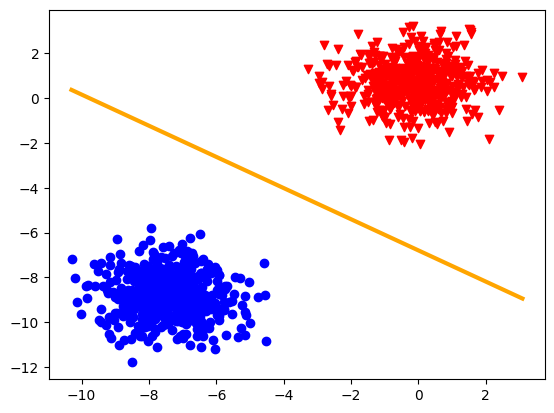

In [7]:

x = np.linspace(np.min(X['x']), np.max(X['x']))
y = df['label']
pyplot.scatter(X['x'][y==0],X['y'][y==0],c='red', marker='v')
pyplot.scatter(X['x'][y==1],X['y'][y==1],c='blue', marker='o')

pyplot.plot(x, -x*w1/w2  - w0/w2, color='orange', linewidth=3, )

pyplot.show()

# Homework 2ravel

Write a function is_kernel_function(func), which will return True if given function is a kernel function and False if it is not.

In [8]:
def is_kernel_function(func):
    # It must be symmetric and
    #positive-semidefinite for proper sampling.
    return True

    #
    return False

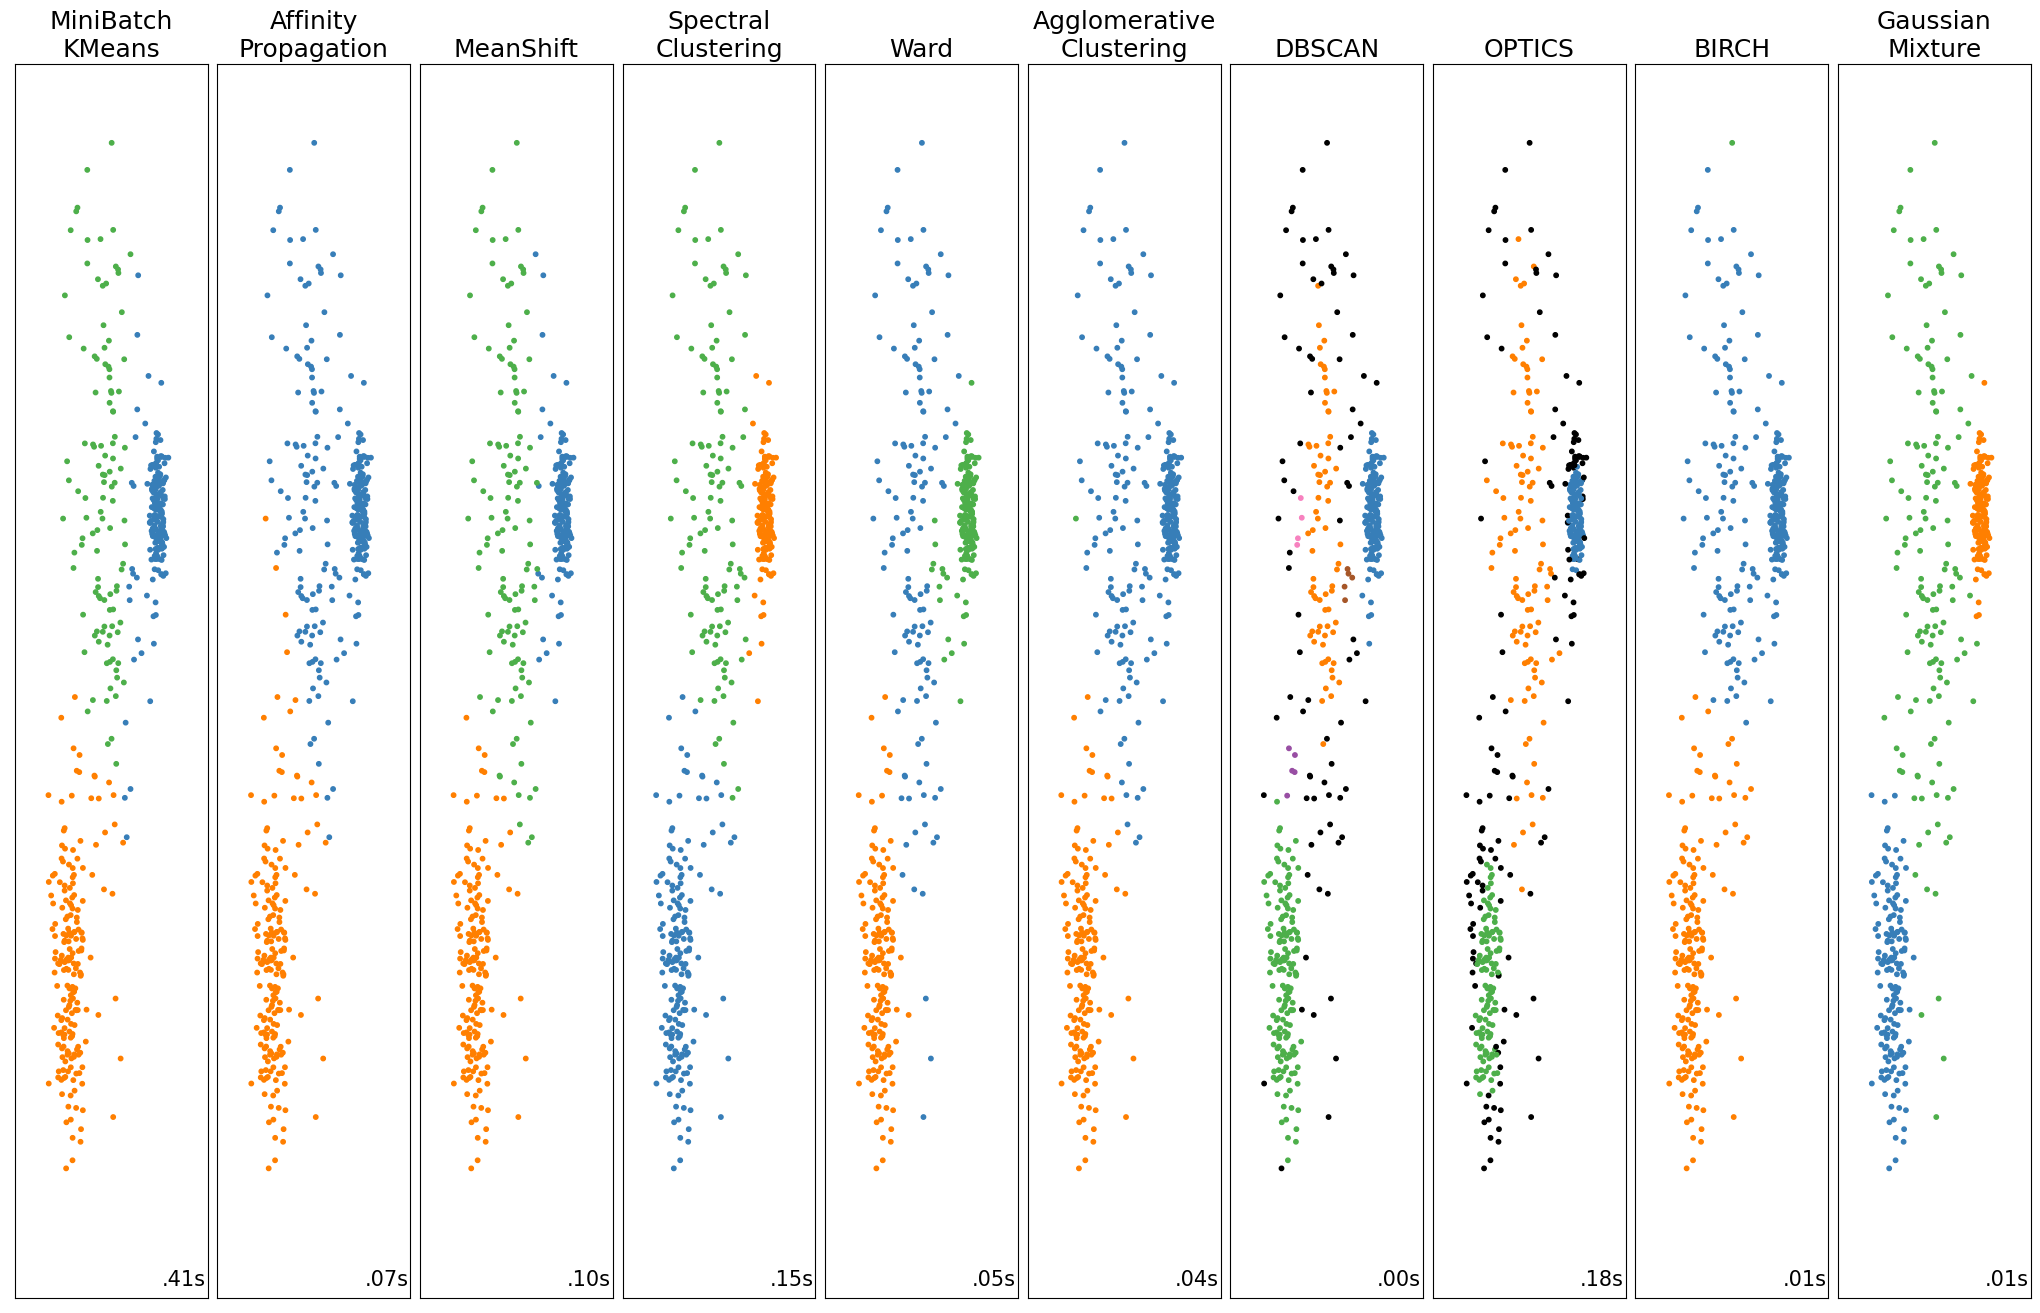

In [13]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

datasets = [
    # (
    #     noisy_circles,
    #     {
    #         "damping": 0.77,
    #         "preference": -240,
    #         "quantile": 0.2,
    #         "n_clusters": 2,
    #         "min_samples": 7,
    #         "xi": 0.08,
    #     },
    # ),
    # (
    #     noisy_moons,
    #     {
    #         "damping": 0.75,
    #         "preference": -220,
    #         "n_clusters": 2,
    #         "min_samples": 7,
    #         "xi": 0.1,
    #     },
    # ),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 7,
            "xi": 0.01,
            "min_cluster_size": 0.2,
        },
    ),
    # (
    #     aniso,
    #     {
    #         "eps": 0.15,
    #         "n_neighbors": 2,
    #         "min_samples": 7,
    #         "xi": 0.1,
    #         "min_cluster_size": 0.2,
    #     },
    # ),
    # (blobs, {"min_samples": 7, "xi": 0.1, "min_cluster_size": 0.2}),
    # (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"], n_init="auto")
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"], preference=params["preference"], random_state=0
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        metric="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"], covariance_type="full"
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()

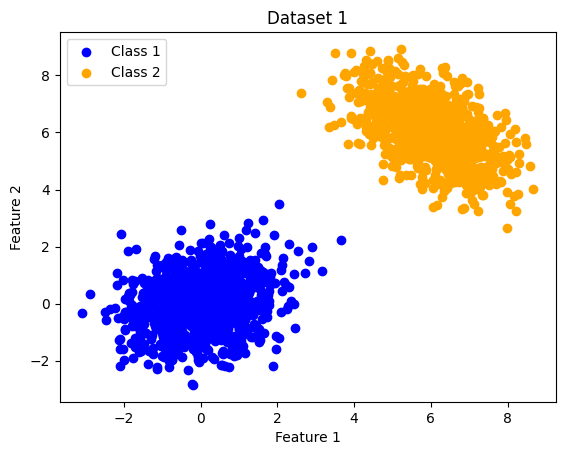

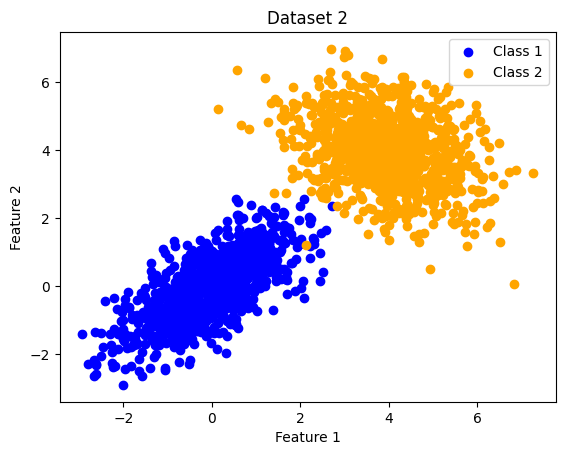

In [376]:
import numpy as np
import matplotlib.pyplot as plt

# Dataset 1
np.random.seed(123)
n_samples = 1000
cov1 = [[1, 0.2], [0.2, 1]]
cov2 = [[1, -0.5], [-0.5, 1]]
mean1 = [0, 0]
mean2 = [6, 6]
X1 = np.random.multivariate_normal(mean1, cov1, n_samples)
X2 = np.random.multivariate_normal(mean2, cov2, n_samples)

# Dataset 2
np.random.seed(456)
cov3 = [[1, 0.7], [0.7, 1]]
cov4 = [[1, -0.3], [-0.3, 1]]
mean3 = [0, 0]
mean4 = [4, 4]
Y1 = np.random.multivariate_normal(mean3, cov3, n_samples)
Y2 = np.random.multivariate_normal(mean4, cov4, n_samples)

# Plot Dataset 1
fig, ax = plt.subplots()
ax.scatter(X1[:, 0], X1[:, 1], c='blue', label='Class 1')
ax.scatter(X2[:, 0], X2[:, 1], c='orange', label='Class 2')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_title('Dataset 1')
ax.legend()
plt.show()

# Plot Dataset 2
fig, ax = plt.subplots()
ax.scatter(Y1[:, 0], Y1[:, 1], c='blue', label='Class 1')
ax.scatter(Y2[:, 0], Y2[:, 1], c='orange', label='Class 2')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_title('Dataset 2')
ax.legend()
plt.show()


In [377]:
import numpy as np

# Generate some random data
np.random.seed(123)
n_samples = 100
x = np.random.normal(size=n_samples)
y = np.random.normal(size=n_samples)

# Calculate covariance using the formula
cov_xy = np.sum((x - np.mean(x)) * (y - np.mean(y))) / (n_samples - 1)
print('Covariance using formula:', cov_xy)

# Calculate covariance using numpy
cov_matrix = np.cov(np.array([x, y]))
cov_xy = cov_matrix[0, 1]

Covariance using formula: -0.021334436856704334


(500,)


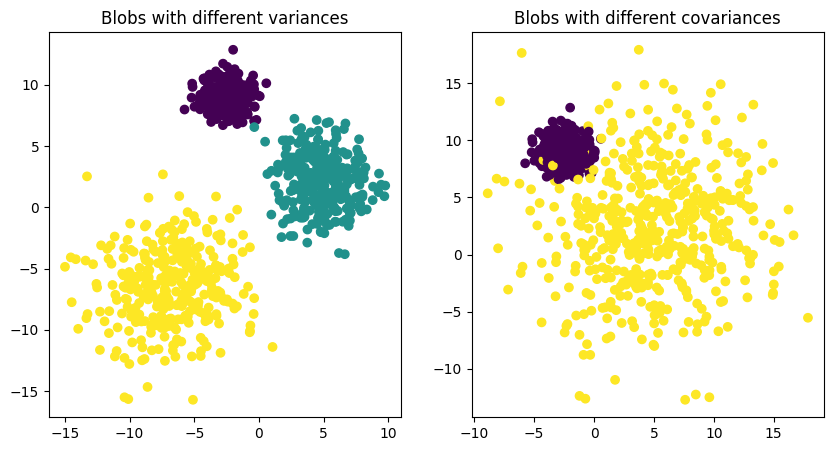

In [411]:
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Generate dataset with blobs of different variances
X1, y1 = make_blobs(n_samples=1000, centers=3, cluster_std=[1.0, 2.0, 3.0], random_state=42)

# Generate dataset with blobs of different covariances
cov = np.array([[1.0, 0.8], [0.8, 1.0]])
X2, y2 = make_blobs(n_samples=1000, centers=2, cluster_std=[1.0, 5.0], random_state=42)
print(y2[y2==0].shape)
# print((y2 == 0).sum())
# X2[y2 == 0] = np.random.multivariate_normal(mean=[-5, -5], cov=cov, size=(y2 == 0).sum())
# X2[y2 == 1] = np.random.multivariate_normal(mean=[0, 0], cov=cov, size=(y2 == 0).sum())
# X2[y2 == 2] = np.random.multivariate_normal(mean=[5, 5], cov=cov, size=(y2 == 0).sum())

# Plot the datasets
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
ax1.scatter(X1[:, 0], X1[:, 1], c=y1, cmap='viridis')
ax1.set_title('Blobs with different variances')
ax2.scatter(X2[:, 0], X2[:, 1], c=y2, cmap='viridis')
ax2.set_title('Blobs with different covariances')
plt.show()

In [403]:
y2[y2==0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,